In [20]:
import numpy as np
import pandas as pd
import time 
import re
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
english_stop_words = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# machine learning

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from sklearn.metrics import classification_report

import seaborn as sns
sns.set(style ='whitegrid')
pd.set_option('display.max_columns',None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saanilkhanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
headers=['Tweet_ID','Entity','Sentiment','Tweet_content']


t_df=pd.read_csv('/Users/saanilkhanna/Documents/Portfolio/Twitter /twitter_training.csv', sep=',', names=headers)

v_df=pd.read_csv('/Users/saanilkhanna/Documents/Portfolio/Twitter /twitter_validation.csv', sep=',', names=headers)

In [22]:
t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [23]:
t_df.head(10)
v_df.head(5)

Tweet_ID     Entity   Sentiment  \
0      3364   Facebook  Irrelevant   
1       352     Amazon     Neutral   
2      8312  Microsoft    Negative   
3      4371      CS-GO    Negative   
4      4433     Google     Neutral   

                                       Tweet_content  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...

In [24]:
t_df.value_counts(normalize=True)

Tweet_ID  Entity                             Sentiment   Tweet_content                                                                                                                  
3018      Dota2                              Positive    Wow.                                                                                                                               0.000068
4050      CS-GO                              Positive    Wow                                                                                                                                0.000068
10181     PlayerUnknownsBattlegrounds(PUBG)  Irrelevant  Really                                                                                                                             0.000068
8808      Nvidia                             Positive    Wow                                                                                                                                0.000068
6928      johnson&johnson  

In [25]:
t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [26]:
t_df['Sentiment'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

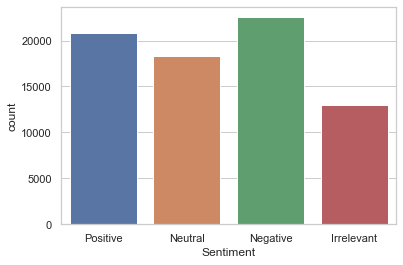

In [27]:
sns.countplot(x=t_df['Sentiment'])

In [28]:
t_df.duplicated().sum()

2700

In [29]:
t_df= t_df.drop_duplicates()

<AxesSubplot:ylabel='Sentiment'>

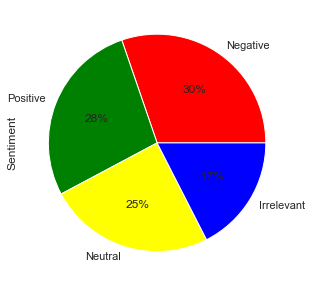

In [30]:
t_df.Sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(5,5),colors=["red", "green", "yellow",'blue'])

<AxesSubplot:xlabel='Entity'>

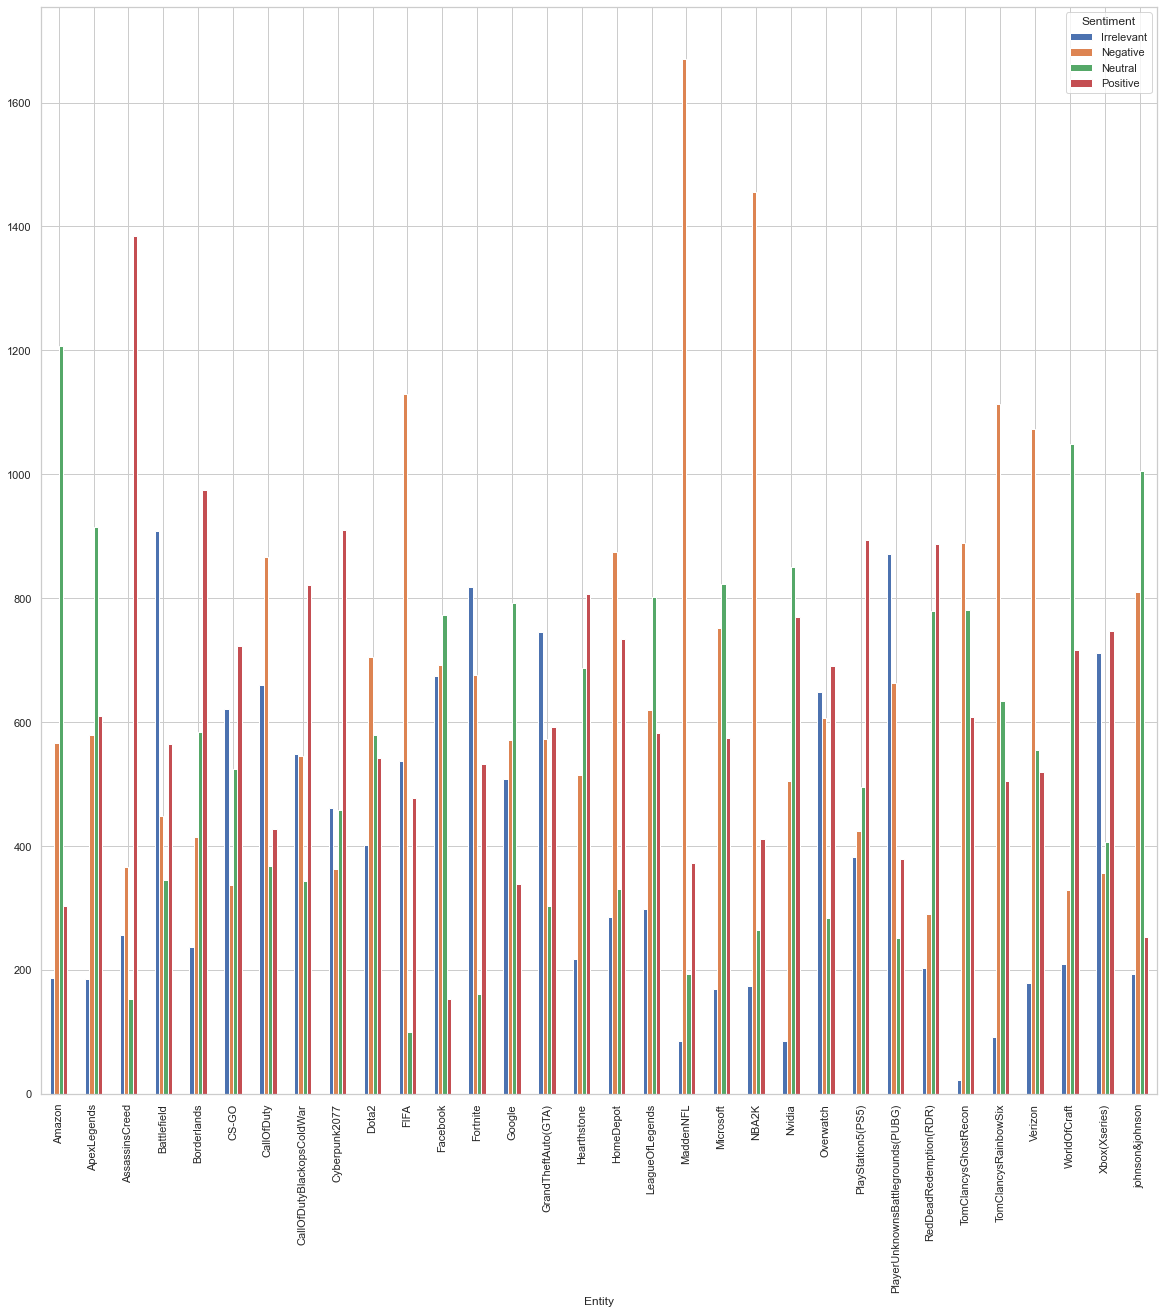

In [31]:
Twitter_sentiment = t_df.groupby(['Entity', 'Sentiment']).Sentiment.count().unstack()
Twitter_sentiment.plot(kind='bar',figsize=(20,20))

In [32]:
# encoder for target feature
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
t_df['Sentiment']=lb.fit_transform(t_df['Sentiment'])

In [33]:
t_df['Tweet_content'].isnull().sum()

326

In [34]:
t_df.dropna(axis=0, inplace=True)

In [ ]:
tweet_train  = t_df["Tweet_content"]
tweet_valid=v_df["Tweet_content"]
target=t_df['Sentiment']

In [ ]:
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "

def preprocess_reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(tweet_train)
reviews_valid_clean = preprocess_reviews(tweet_valid)

In [ ]:
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words

no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_valid = remove_stop_words(reviews_valid_clean)

In [ ]:
no_stop_words_valid

['mentioned facebook struggling motivation go run day, translated tom‚Äôs great auntie ‚Äòhayley can‚Äôt get bed‚Äô told grandma, thinks i‚Äôm lazy, terrible person ü§£',
 "bbc news - amazon boss jeff bezos rejects claims company acted like 'drug dealer' bbc.co.uk/news/av/busine‚Ä¶",
 'microsoft pay word functions poorly samsungus chromebook? üôÑ',
 'csgo matchmaking full closet hacking, truly awful game.',
 'president slapping americans face really commit unlawful act acquittal! discover google vanityfair.com/news/2020/02/t‚Ä¶',
 'hi eahelp i‚Äôve madeleine mccann cellar past 13 years little sneaky thing escaped whilst loading fifa points, took card i‚Äôm use paypal account isn‚Äôt working, help resolve please?',
 'thank eamaddennfl!! new te austin hooper orange & brown!! #browns | austinhooper18 pic.twitter.com/grg4xzfkon',
 'rocket league, sea thieves rainbow six: siegeü§î? love playing three stream best? #stream #twitch #rocketleague #seaofthieves #rainbowsixsiege #follow',
 'as

In [ ]:
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews_train = get_stemmed_text(no_stop_words_train)
stemmed_reviews_test = get_stemmed_text(no_stop_words_valid)

In [ ]:
stemmed_reviews_test

['mention facebook struggl motiv go run day, translat tom‚Äô great aunti ‚Äòhayley can‚Äôt get bed‚Äô told grandma, think i‚Äôm lazy, terribl person ü§£',
 "bbc news - amazon boss jeff bezo reject claim compani act like 'drug dealer' bbc.co.uk/news/av/busine‚Ä¶",
 'microsoft pay word function poorli samsungu chromebook? üôÑ',
 'csgo matchmak full closet hacking, truli aw game.',
 'presid slap american face realli commit unlaw act acquittal! discov googl vanityfair.com/news/2020/02/t‚Ä¶',
 'hi eahelp i‚Äôv madelein mccann cellar past 13 year littl sneaki thing escap whilst load fifa points, took card i‚Äôm use paypal account isn‚Äôt working, help resolv please?',
 'thank eamaddennfl!! new te austin hooper orang & brown!! #brown | austinhooper18 pic.twitter.com/grg4xzfkon',
 'rocket league, sea thiev rainbow six: siegeü§î? love play three stream best? #stream #twitch #rocketleagu #seaofthiev #rainbowsixsieg #follow',
 'ass still knee-deep assassin creed odyssey way anytim soon lmao',


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(stemmed_reviews_train)
X = tfidf_vectorizer.transform(stemmed_reviews_train)
X_test = tfidf_vectorizer.transform(stemmed_reviews_test)

In [ ]:
print(X_test)

  (0, 26094)	0.26403218722549693
  (0, 25920)	0.2410517867093456
  (0, 25915)	0.20479418101317756
  (0, 25613)	0.15021964196083884
  (0, 25331)	0.19913565179546974
  (0, 24549)	0.2333958318808056
  (0, 22148)	0.17286860091651976
  (0, 19413)	0.1834359162154656
  (0, 17226)	0.2800513503017872
  (0, 16633)	0.21815252768236235
  (0, 15215)	0.2987284932796618
  (0, 12302)	0.3200867580773737
  (0, 11745)	0.13927694914084005
  (0, 11707)	0.28148479306861934
  (0, 11486)	0.12218095578199796
  (0, 11217)	0.1126134443899632
  (0, 9657)	0.1387869211652127
  (0, 7346)	0.1410715443125771
  (0, 5129)	0.1377189514483578
  (0, 3812)	0.24226031269138334
  (0, 3244)	0.2987284932796618
  (1, 26643)	0.17633857704970574
  (1, 21326)	0.24278825080135139
  (1, 17802)	0.2983311180931276
  (1, 15487)	0.10717394323489159
  :	:
  (997, 13876)	0.186714016960072
  (997, 12261)	0.2523572498066803
  (997, 8412)	0.39683952034825243
  (997, 7346)	0.2152135899091668
  (997, 6165)	0.2242800851442482
  (997, 4509)	0.233

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.75)

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=300, random_state=0)
text_classifier.fit(X_train, y_train)

y_pred=text_classifier.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      3195
           1       0.92      0.94      0.93      5413
           2       0.94      0.90      0.92      4451
           3       0.86      0.94      0.90      4855

    accuracy                           0.91     17914
   macro avg       0.92      0.91      0.91     17914
weighted avg       0.92      0.91      0.92     17914



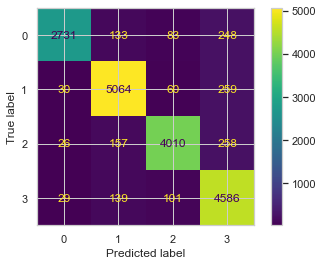

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()